# Time Series Mini Project
Data: Global Land Temperatures By City
    https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [1]:
import pandas as pd
import numpy as np

import project_wrangle as w
import project_explore as ex

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import warnings
warnings.filterwarnings("ignore")

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

In [2]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)

## Acquire my Data

In [3]:
df = pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [4]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [5]:
# narrow down to the city I want
df = df[df['City']=='Berlin']

In [6]:
w.get_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 855342 to 858580
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             3239 non-null   object 
 1   AverageTemperature             3166 non-null   float64
 2   AverageTemperatureUncertainty  3166 non-null   float64
 3   City                           3239 non-null   object 
 4   Country                        3239 non-null   object 
 5   Latitude                       3239 non-null   object 
 6   Longitude                      3239 non-null   object 
dtypes: float64(2), object(5)
memory usage: 202.4+ KB
None

------------------------

This dataframe has 3239 rows and 7 columns.

------------------------

Null count in dataframe:
------------------------
dt                                0
AverageTemperature               73
AverageTemperatureUncertainty    73
City                            

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
857769,1946-02-01,2.386,0.287,Berlin,Germany,52.24N,13.14E
857617,1933-06-01,15.887,0.310,Berlin,Germany,52.24N,13.14E
857121,1892-02-01,0.922,0.368,Berlin,Germany,52.24N,13.14E


### Acquire Takeaways:
 - Brought in data from csv file
 - Used info function to get a quick scope of our dataframe
 - Most of the columns probably have the same entry in them
 - I will have to rename columns and assess the nulls
 

## Prepare Data

In [7]:
# lower case the columns
df = df.rename(str.lower, axis='columns')

In [8]:
# first rename columns
df.rename(columns={'dt':'date',
                   'averagetemperature': 'avg_temp',
                   'averagetemperatureuncertainty': 'avg_temp_uncertainty'
}, inplace=True)

In [9]:
df.dtypes

date                     object
avg_temp                float64
avg_temp_uncertainty    float64
city                     object
country                  object
latitude                 object
longitude                object
dtype: object

In [10]:
# set date as datetime 
df.date = pd.to_datetime(df.date)

# set date as index
df = df.set_index('date')

In [11]:
# get a value count of lat and long to see if they need to be dropped
w.value_counts(df, df.columns)

avg_temp
3.816     3
16.932    3
18.829    3
4.122     2
18.173    2
         ..
14.099    1
1.517     1
2.551     1
7.117     1
7.375     1
Name: avg_temp, Length: 3030, dtype: int64
-------------
avg_temp_uncertainty
0.214    13
0.265    13
0.213    11
0.238    11
0.226    11
         ..
2.527     1
2.681     1
1.089     1
4.133     1
1.000     1
Name: avg_temp_uncertainty, Length: 1792, dtype: int64
-------------
city
Berlin    3239
Name: city, dtype: int64
-------------
country
Germany    3239
Name: country, dtype: int64
-------------
latitude
52.24N    3239
Name: latitude, dtype: int64
-------------
longitude
13.14E    3239
Name: longitude, dtype: int64
-------------


In [12]:
df.columns

Index(['avg_temp', 'avg_temp_uncertainty', 'city', 'country', 'latitude',
       'longitude'],
      dtype='object')

In [13]:
df.tail(10)

,avg_temp,avg_temp_uncertainty,city,country,latitude,longitude
date,,,,,,
2012-12-01,0.999,0.293,Berlin,Germany,52.24N,13.14E
2013-01-01,0.113,0.285,Berlin,Germany,52.24N,13.14E
2013-02-01,0.314,0.260,Berlin,Germany,52.24N,13.14E
2013-03-01,-0.391,0.291,Berlin,Germany,52.24N,13.14E
2013-04-01,9.088,0.295,Berlin,Germany,52.24N,13.14E
2013-05-01,14.139,0.196,Berlin,Germany,52.24N,13.14E
2013-06-01,17.473,0.236,Berlin,Germany,52.24N,13.14E
2013-07-01,20.901,0.161,Berlin,Germany,52.24N,13.14E
2013-08-01,19.335,0.265,Berlin,Germany,52.24N,13.14E


In [14]:
# drop all other columns since they only have one entry
df = df[['avg_temp', 'avg_temp_uncertainty']]

In [15]:
# assess the nulls
df.isnull().sum()

avg_temp                73
avg_temp_uncertainty    73
dtype: int64

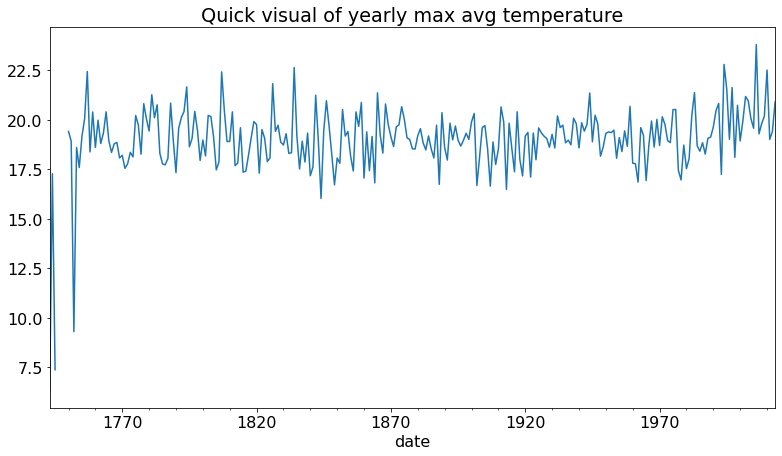

In [16]:
df.resample('Y').max().avg_temp.plot()
plt.title('Quick visual of yearly max avg temperature');

In [17]:
# drop those outliers at the beginning
df = df.loc['1770':'2014']

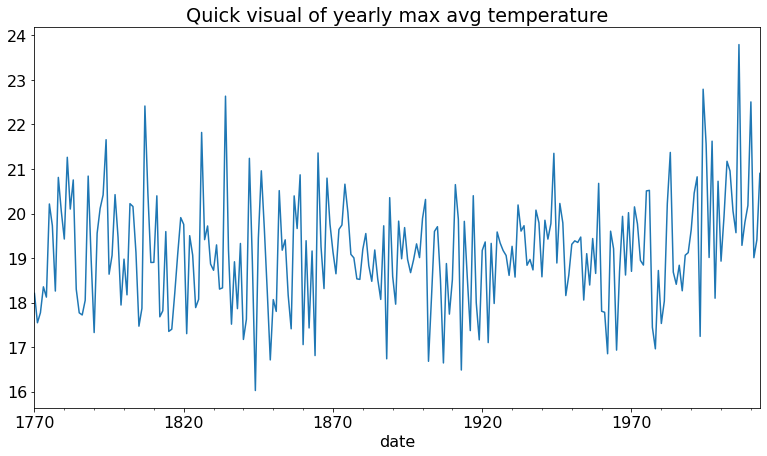

In [18]:
# get another quick look
df.resample('Y').max().avg_temp.plot()
plt.title('Quick visual of yearly max avg temperature');

In [19]:
# use interpoltate method to fill the nulls
df = df.interpolate(method='linear') # use lingear method to fill nulls

In [20]:
df.isnull().sum()

avg_temp                0
avg_temp_uncertainty    0
dtype: int64

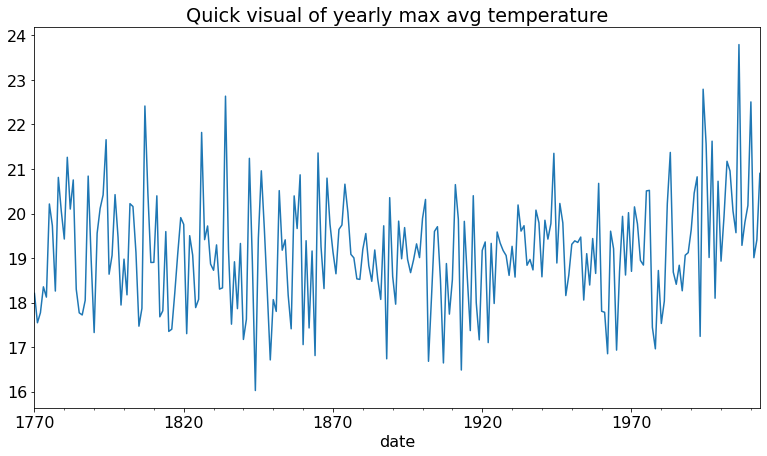

In [21]:
# get another quick look
df.resample('Y').max().avg_temp.plot()
plt.title('Quick visual of yearly max avg temperature');

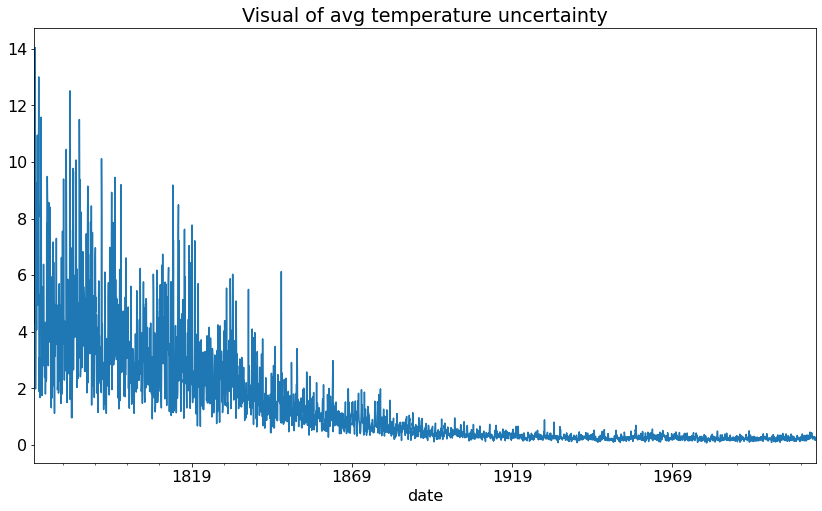

In [22]:
# plot the temp uncertainty to gauge how inaccurate some of the data can be
plt.figure(figsize=(14,8))
df.avg_temp_uncertainty.plot()
plt.title('Visual of avg temperature uncertainty');

- We don't want to have data that can be inaccurate by over 10 degrees. 

In [23]:
# narrow my dataframe even more to kick out the variable data
df = df.loc['1864':'2014']

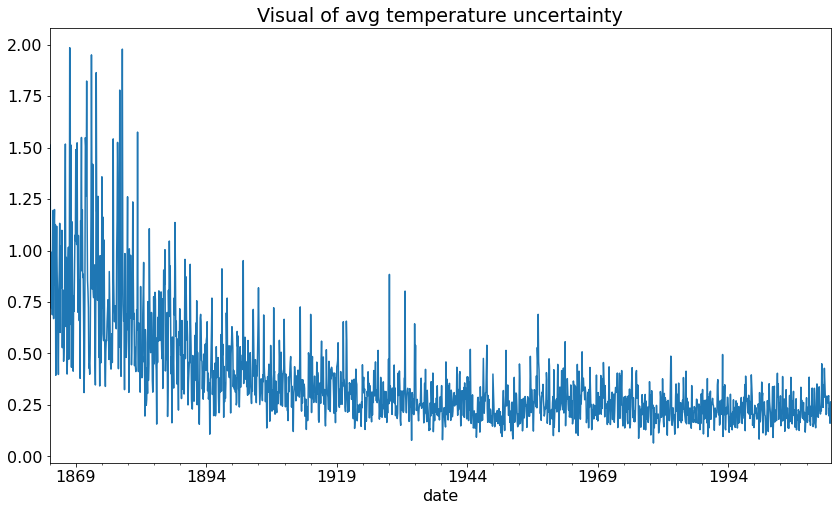

In [24]:
# plot the temp uncertainty to gauge how inaccurate some of the data can be
plt.figure(figsize=(14,8))
df.avg_temp_uncertainty.plot()
plt.title('Visual of avg temperature uncertainty');

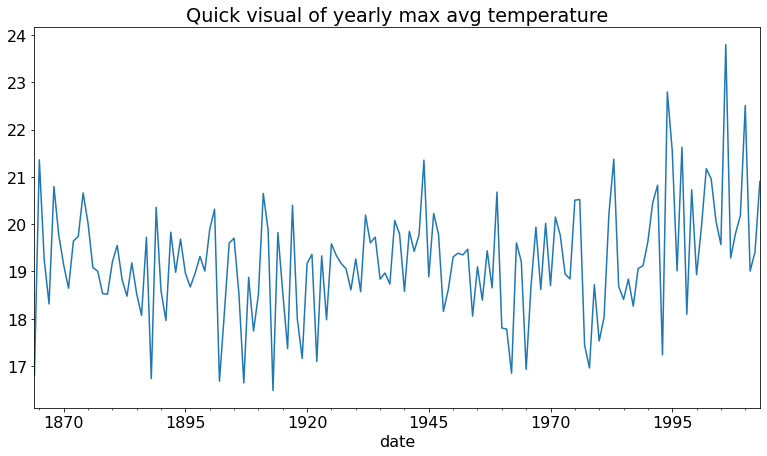

In [25]:
# get another quick look to see how we'll split our data
df.resample('Y').max().avg_temp.plot()
plt.title('Quick visual of yearly max avg temperature');

In [26]:
# make a month and year column for exploration
df['month'] = df.index.month
df['year'] = df.index.year

In [27]:
df.head()

,avg_temp,avg_temp_uncertainty,month,year
date,,,,
1864-01-01,-5.448,0.899,1,1864
1864-02-01,-0.487,1.513,2,1864
1864-03-01,4.669,0.826,3,1864
1864-04-01,6.071,0.809,4,1864
1864-05-01,9.920,0.719,5,1864


In [28]:
# now we can split our data

def time_series_split_data(df):
    '''
    This function takes in a dataframe and splits it into a train, validate, and test set
    with respect to time
    '''
    
    # assign lengtgs of each dataframe
    train_size = int(len(df) * 0.6)
    validate_size = int(len(df) * 0.3)
    test_size = int(len(df) - train_size - validate_size)
    
    validate_end_index = train_size + validate_size
    
    # assign rows to each dataframe
    train = df[:train_size]
    validate = df[train_size:validate_end_index]
    test = df[validate_end_index:]
    
    return train, validate, test

In [29]:
train, validate, test = time_series_split_data(df)

In [30]:
train.shape, validate.shape, test.shape

((1078, 4), (539, 4), (180, 4))

In [31]:
# verify
print(df.head(1) == train.head(1))
print('----')
pd.concat([train.tail(1), validate.head(1)])

            avg_temp  avg_temp_uncertainty  month  year
date                                                   
1864-01-01      True                  True   True  True
----


,avg_temp,avg_temp_uncertainty,month,year
date,,,,
1953-10-01,11.578,0.207,10,1953
1953-11-01,5.545,0.153,11,1953


In [32]:
# verify they should be consecutive
pd.concat([validate.tail(1), test.head(1)])

,avg_temp,avg_temp_uncertainty,month,year
date,,,,
1998-09-01,14.538,0.151,9,1998
1998-10-01,9.080,0.205,10,1998


In [33]:
# verify they should be the same
pd.concat([test.tail(1), df.tail(1)])

,avg_temp,avg_temp_uncertainty,month,year
date,,,,
2013-09-01,19.335,0.265,9,2013
2013-09-01,19.335,0.265,9,2013


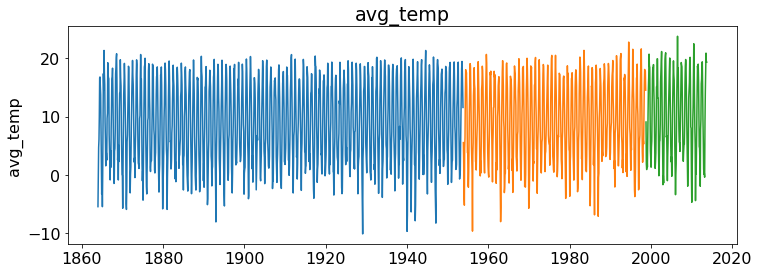

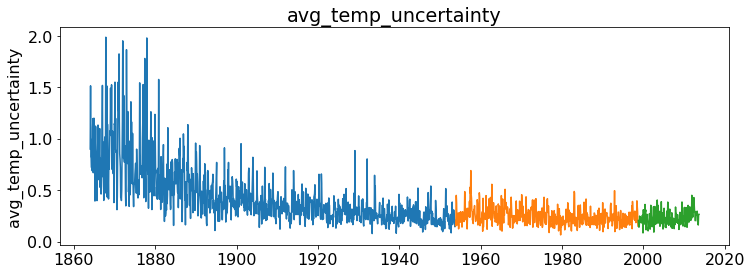

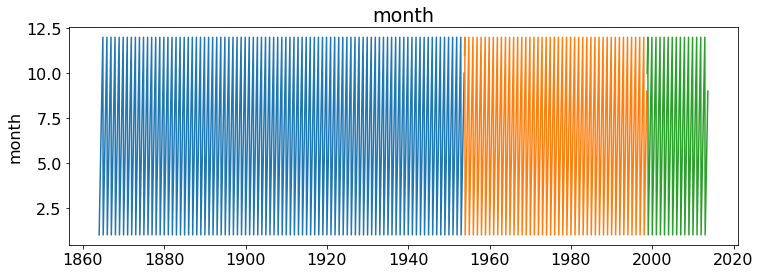

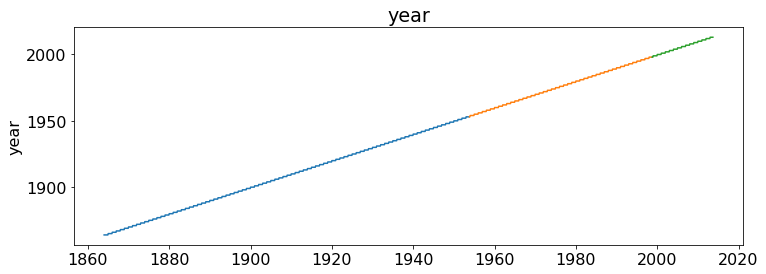

In [34]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### Prepare Takeaways:
   - I went ahead and lowercased then renamed my columns
   - I used .interpolate to fill my nulls with respect to linear correlation
   - I assessed my temp variability and dropped years with more than 2 degree variable estimates
   - I split my data and verified it was split accordingly

## Explore

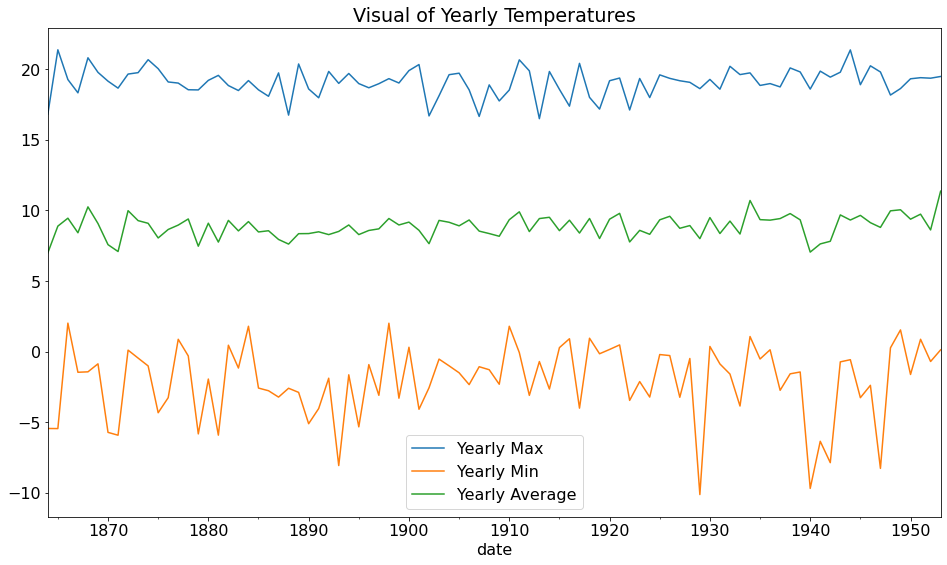

In [35]:
# Yearly temp max, min and average
plt.figure(figsize=(16,9))
train.resample('Y').max().avg_temp.plot(label='Yearly Max')
train.resample('Y').min().avg_temp.plot(label='Yearly Min')
train.resample('Y').mean().avg_temp.plot(label='Yearly Average')
plt.legend()
plt.title('Visual of Yearly Temperatures');

In [36]:
# assign y target
y = train.avg_temp

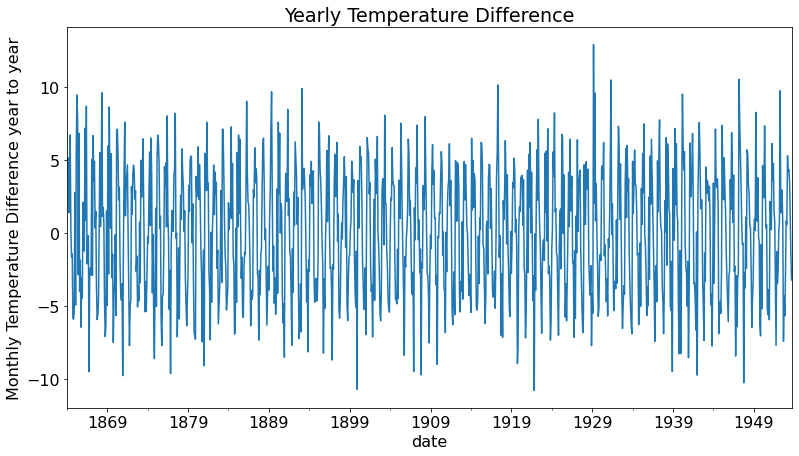

In [37]:
# plot yearly temp difference
y.diff().plot()
plt.title('Yearly Temperature Difference')
plt.ylabel('Monthly Temperature Difference year to year');

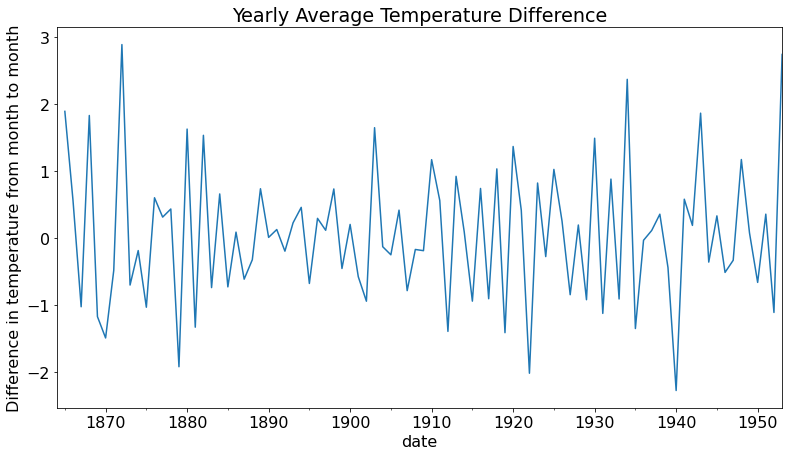

In [38]:
train.resample('Y').avg_temp.mean().diff().plot()
plt.title('Yearly Average Temperature Difference')
plt.ylabel('Difference in temperature from month to month');

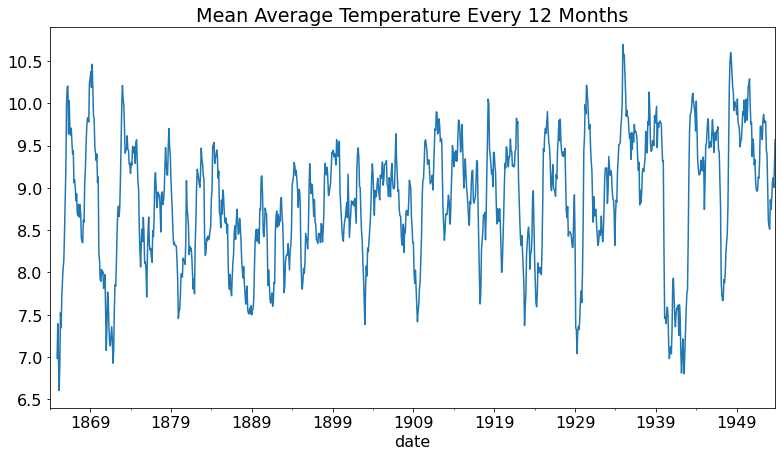

In [39]:
y.rolling(12).mean().plot()
plt.title('Mean Average Temperature Every 12 Months');

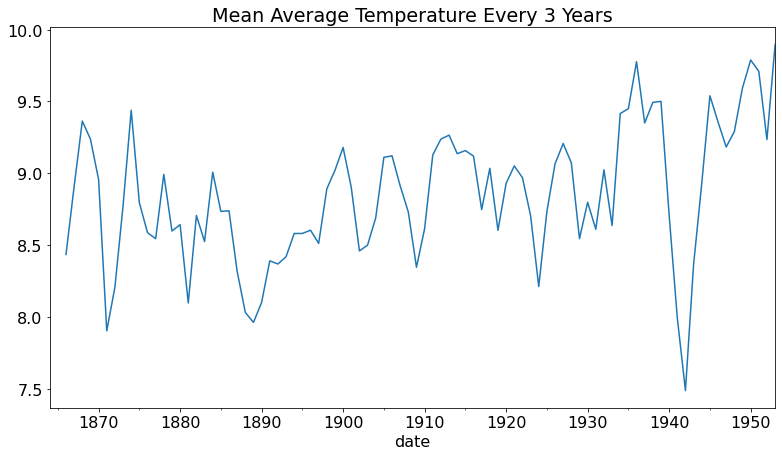

In [40]:
train.resample('Y').mean().avg_temp.rolling(3).mean().plot()
plt.title('Mean Average Temperature Every 3 Years');

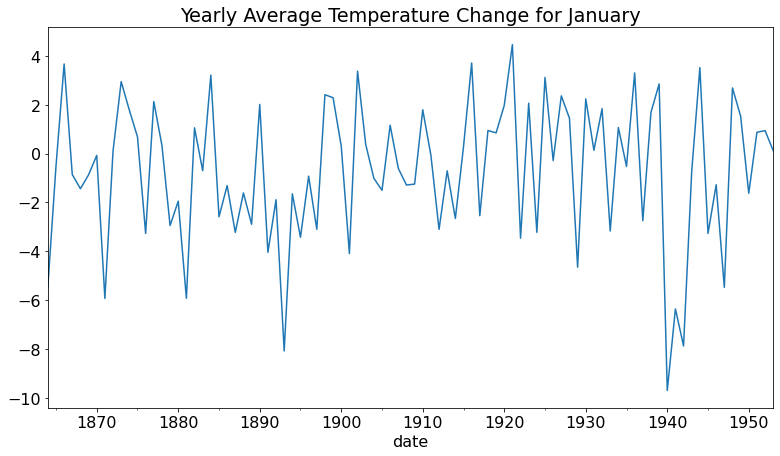

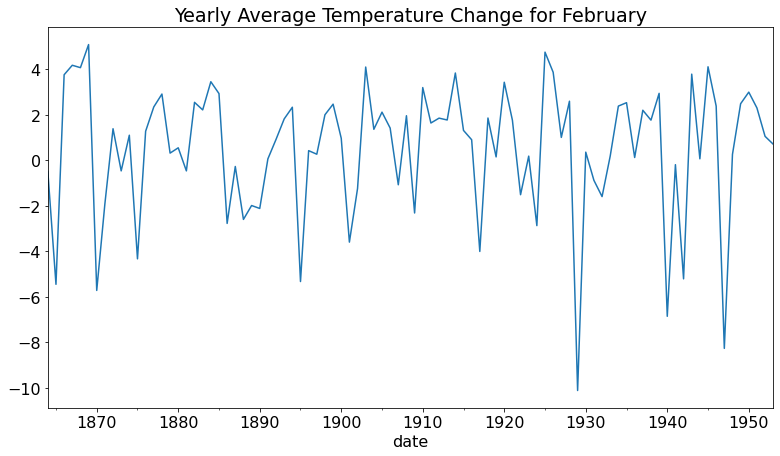

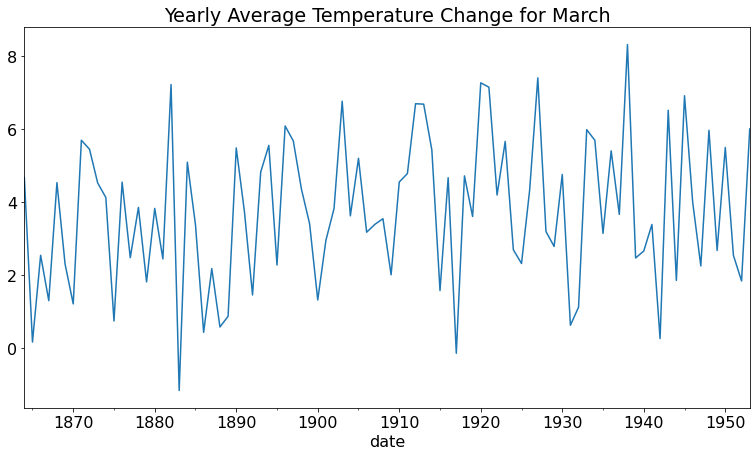

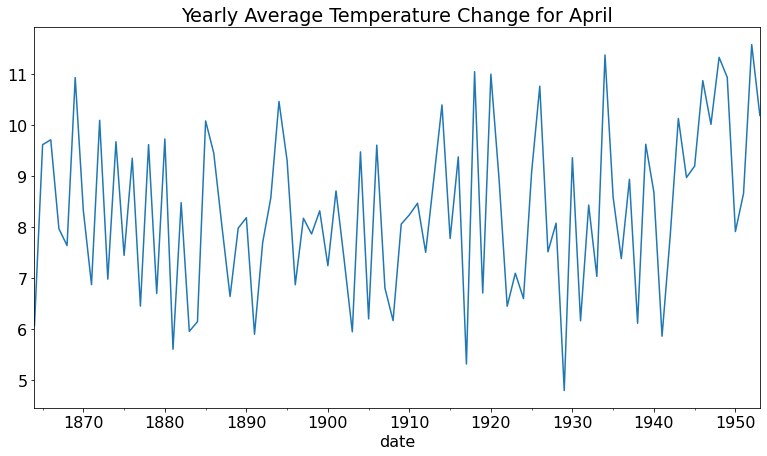

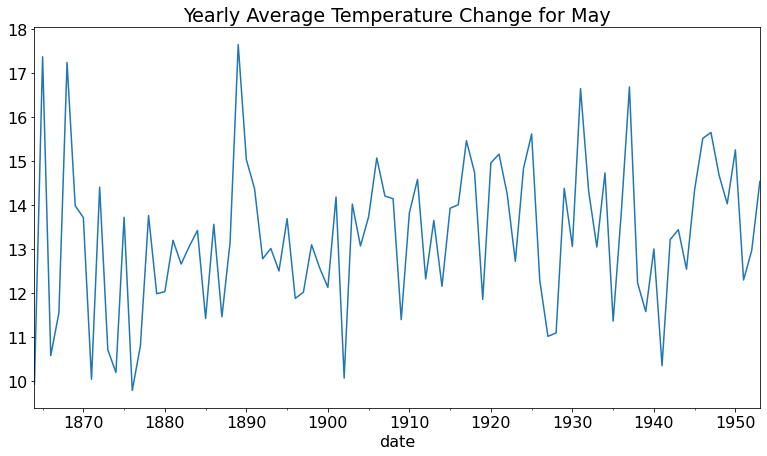

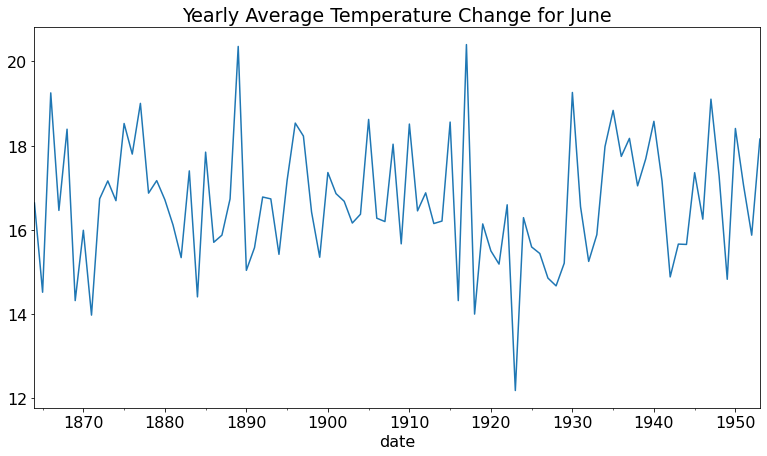

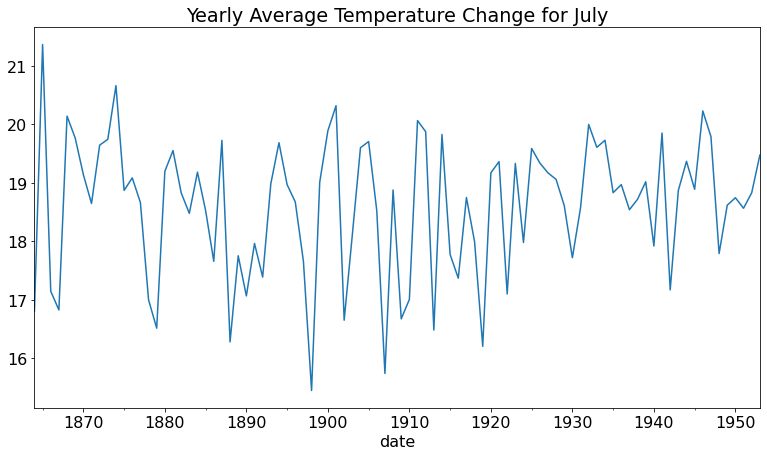

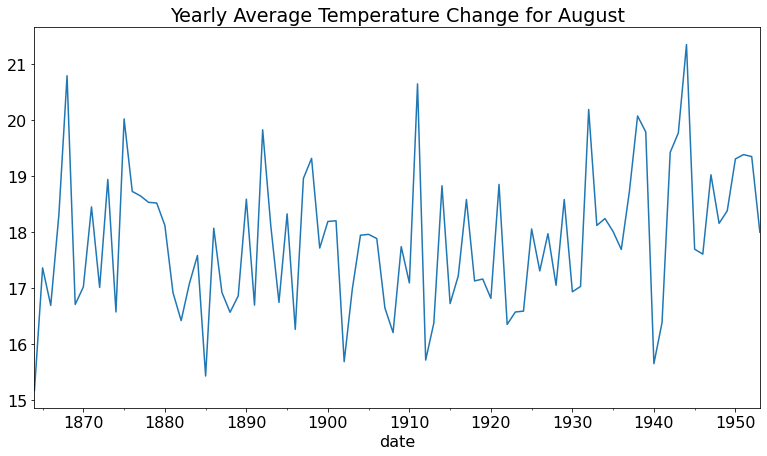

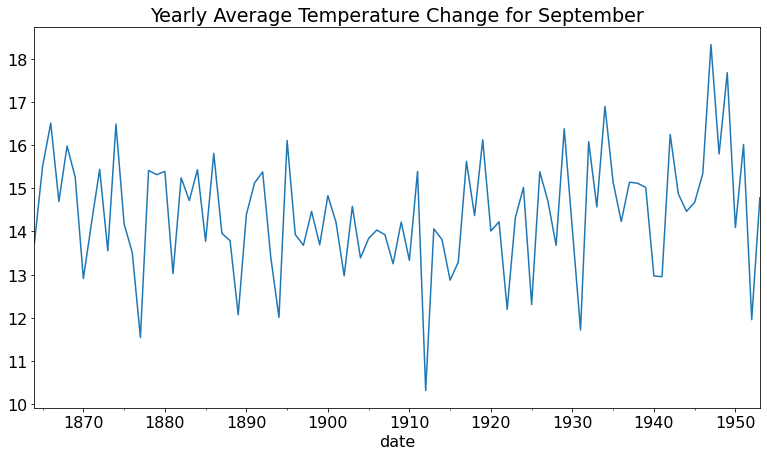

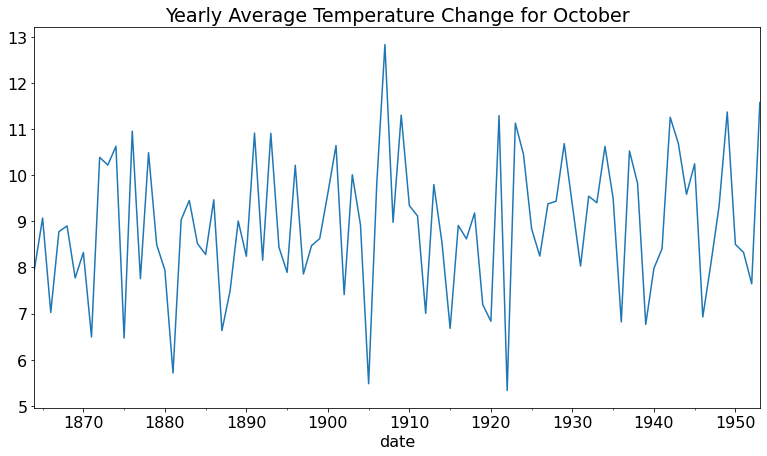

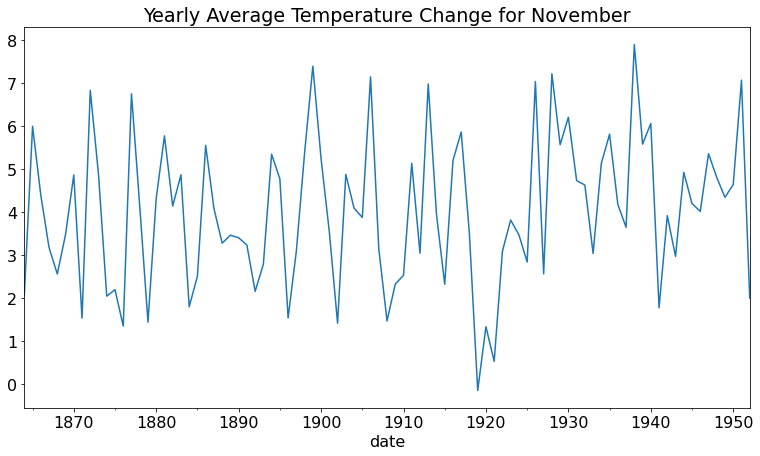

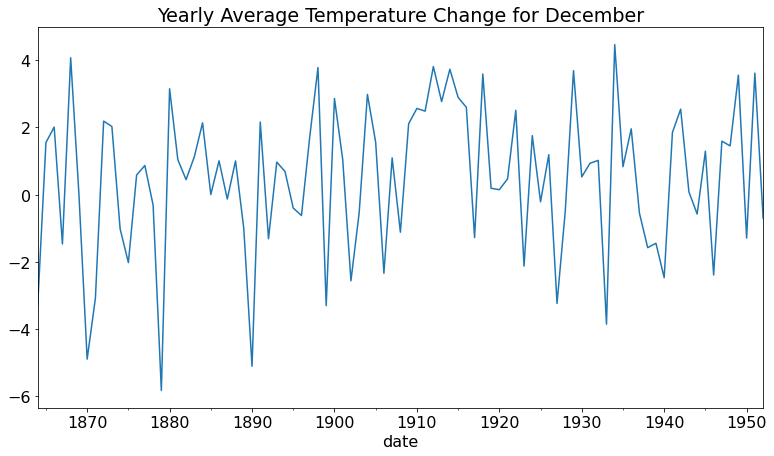

In [42]:
# is there a linear trend in monthly avg year to year?

for i in range (1,13):
    train[train.month==i].avg_temp.plot()
    if i==1:
        i='January'
        plt.title('Yearly Average Temperature Change for '+i)
    if i==2:
        i='February'
        plt.title('Yearly Average Temperature Change for '+i)
    if i==3:
        i='March'
        plt.title('Yearly Average Temperature Change for '+i)
    if i==4:
        i='April'
        plt.title('Yearly Average Temperature Change for '+i)
    if i==5:
        i='May'
        plt.title('Yearly Average Temperature Change for '+i)
    if i==6:
        i='June'
        plt.title('Yearly Average Temperature Change for '+i)
    if i==7:
        i='July'
        plt.title('Yearly Average Temperature Change for '+i)
    if i==8:
        i='August'
        plt.title('Yearly Average Temperature Change for '+i)
    if i==9:
        i='September'
        plt.title('Yearly Average Temperature Change for '+i)
    if i==10:
        i='October'
        plt.title('Yearly Average Temperature Change for '+i)
    if i==11:
        i='November'
        plt.title('Yearly Average Temperature Change for '+i)
    elif i==12:
        i='December'
        plt.title('Yearly Average Temperature Change for '+i)

    plt.show()

### Explore Takeaways
 - Using resampling for the data by month, year and 12-36 months gives us different visual trends.
 - Grouping the dataframe by 12 months and 36 months let's us see more if a linear trend upward.
 - Some of the monthly trends show a positive trend such as October and May
 - In modeling I will move forward with monthly average temperature and utitilize rolling/resampling methods for the moving average model.

## Modeling

### Simple Average

In [82]:
overall_mean_temp = round(train.avg_temp.mean(), 2)
yhat_validate = pd.DataFrame({'yhat_temp':[overall_mean_temp]}, index = validate.index)
yhat_validate.head()

,yhat_temp
date,
1953-11-01,8.85
1953-12-01,8.85
1954-01-01,8.85
1954-02-01,8.85
1954-03-01,8.85


In [83]:
validate.head()

,avg_temp,avg_temp_uncertainty,month,year
date,,,,
1953-11-01,5.545,0.153,11,1953
1953-12-01,2.509,0.214,12,1953
1954-01-01,-3.666,0.449,1,1954
1954-02-01,-5.193,0.376,2,1954
1954-03-01,4.570,0.160,3,1954


-- RMSE: 7.052384647949551


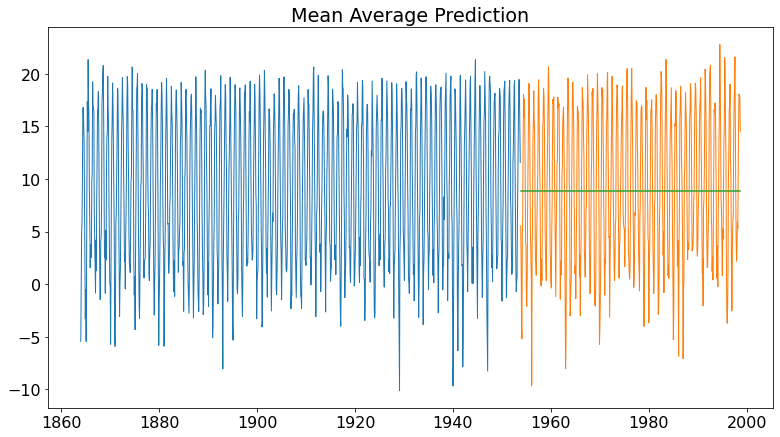

In [85]:
plt.plot(train.avg_temp, label='Train', linewidth=1)
plt.plot(validate.avg_temp, label='Validate', linewidth=1)
plt.plot(yhat_validate.yhat_temp)
plt.title('Mean Average Prediction')
rmse = sqrt(mean_squared_error(validate.avg_temp, yhat_validate.yhat_temp))
print('-- RMSE:', rmse)
plt.show();

Using the mean average temperature on the train data set to predict on the validate set, we have an RMSE of 7 which means the average predictions on unseen data are off by 7 degrees. This is quite a bit for celsius.

### Last Observed

In [86]:
last_obs = round(train['avg_temp'][-1:][0], 2)

yhat_validate = pd.DataFrame({'last_obs_temp': [last_obs]}, 
                      index = validate.index)

yhat_validate.head()

,last_obs_temp
date,
1953-11-01,11.58
1953-12-01,11.58
1954-01-01,11.58
1954-02-01,11.58
1954-03-01,11.58


-- RMSE: 7.424258089780653


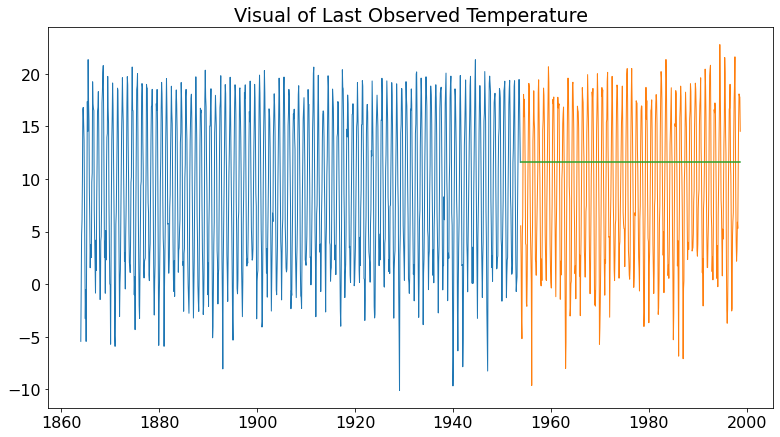

In [87]:
# plot the prediction versus actual
plt.plot(train.avg_temp, label='Train', linewidth=1)
plt.plot(validate.avg_temp, label='Validate', linewidth=1)
plt.plot(yhat_validate.last_obs_temp)
plt.title('Visual of Last Observed Temperature')
rmse = sqrt(mean_squared_error(validate.avg_temp, yhat_validate.last_obs_temp))
print('-- RMSE:', rmse)
plt.show();

Using the last observed temperature on the train data set to predict on the validate set, we have an RMSE of 7 which means the average predictions on unseen data are off by 7 degrees. This is quite a bit for celsius.

### Moving Average

In [88]:
# Let's first use the 12 month rolling average since we got a good visual out of that
twelve_month_avg = round(train['avg_temp'].rolling(12).mean()[-1], 2)

yhat_validate = pd.DataFrame({'twelve_month_avg': [twelve_month_avg]}, 
                      index = validate.index)

yhat_validate.head()

,twelve_month_avg
date,
1953-11-01,9.57
1953-12-01,9.57
1954-01-01,9.57
1954-02-01,9.57
1954-03-01,9.57


-- RMSE: 7.0504430959849405


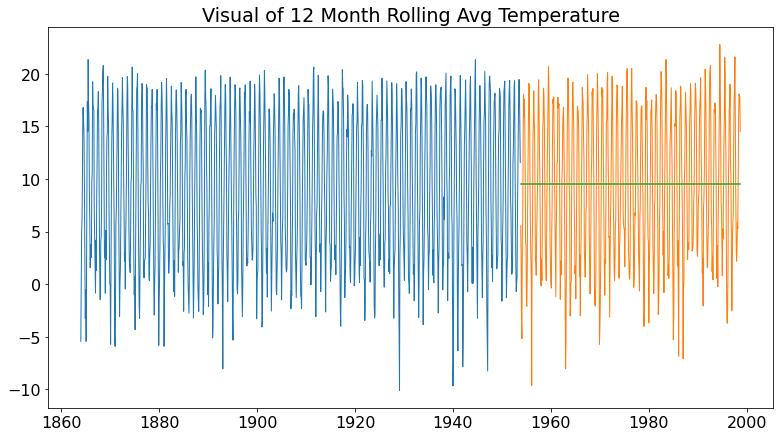

In [89]:
# plot the 12 month prediction versus actual
plt.plot(train.avg_temp, label='Train', linewidth=1)
plt.plot(validate.avg_temp, label='Validate', linewidth=1)
plt.plot(yhat_validate.twelve_month_avg)
plt.title('Visual of 12 Month Rolling Avg Temperature')
rmse = sqrt(mean_squared_error(validate.avg_temp, yhat_validate.twelve_month_avg))
print('-- RMSE:', rmse)
plt.show();

-- RMSE: 7.049055875807748


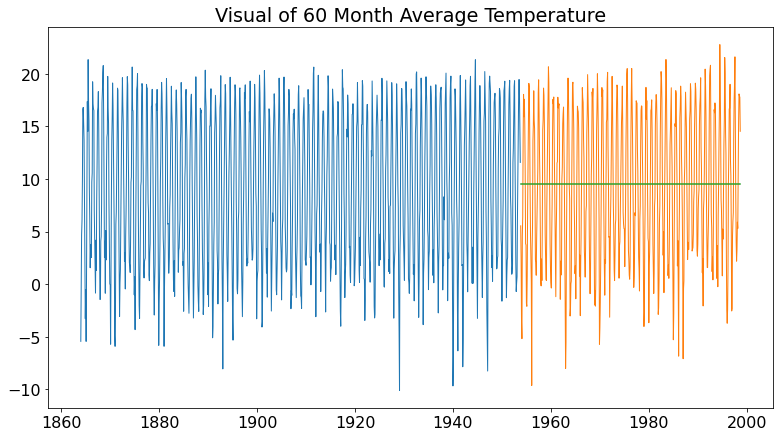

In [91]:
# Now let's try 60 month rolling average since we also got a good visual out of that
sixty_month_avg = round(train['avg_temp'].rolling(60).mean()[-1], 2)

yhat_validate = pd.DataFrame({'sixty_month_avg': [sixty_month_avg]}, 
                      index = validate.index)

# plot the 60 month prediction versus actual
plt.plot(train.avg_temp, label='Train', linewidth=1)
plt.plot(validate.avg_temp, label='Validate', linewidth=1)
plt.plot(yhat_validate.sixty_month_avg)
plt.title('Visual of 60 Month Average Temperature')
rmse = sqrt(mean_squared_error(validate.avg_temp, yhat_validate.sixty_month_avg))
print('-- RMSE:', rmse)
plt.show();

-- RMSE: 7.043410685419952


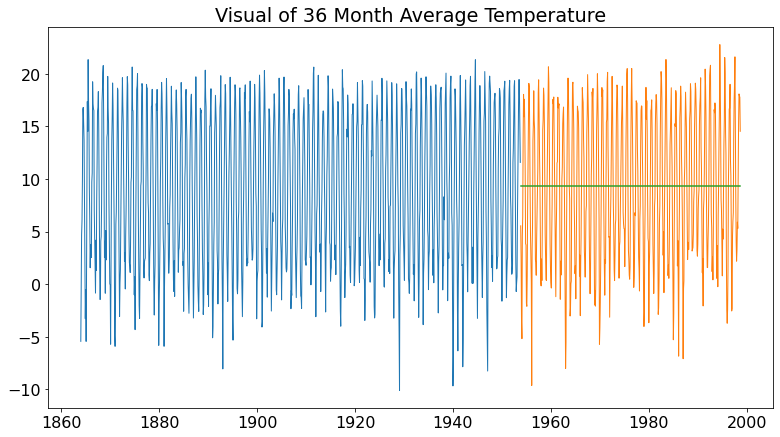

In [92]:
# Now let's try 36 month rolling average since we also got a good visual out of that
thirtysix_month_avg = round(train['avg_temp'].rolling(36).mean()[-1], 2)

yhat_validate = pd.DataFrame({'thirtysix_month_avg': [thirtysix_month_avg]}, 
                      index = validate.index)

# plot the 36 month prediction versus actual
plt.plot(train.avg_temp, label='Train', linewidth=1)
plt.plot(validate.avg_temp, label='Validate', linewidth=1)
plt.plot(yhat_validate.thirtysix_month_avg)
plt.title('Visual of 36 Month Average Temperature')
rmse = sqrt(mean_squared_error(validate.avg_temp, yhat_validate.thirtysix_month_avg))
print('-- RMSE:', rmse)
plt.show();

### Modeling Takeaways:
 - All the models performed similary with an RMSE of 7 and change
 - We can just use our last model with the rolling average for 36 months since it narrowly beat the others

#### Test Model

--Validate RMSE: 7.043410685419952
--Test RMSE: 7.157019980410841


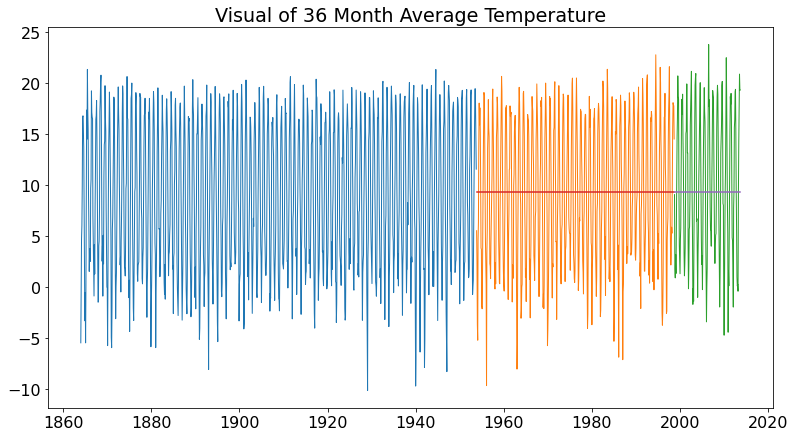

In [95]:
thirtysix_month_avg = round(train['avg_temp'].rolling(36).mean()[-1], 2)

yhat_validate = pd.DataFrame({'thirtysix_month_avg': [thirtysix_month_avg]}, 
                      index = validate.index)

yhat_test = pd.DataFrame({'thirtysix_month_avg': [thirtysix_month_avg]}, 
                      index = test.index)

# plot the 36 month prediction versus actual
plt.plot(train.avg_temp, label='Train', linewidth=1)
plt.plot(validate.avg_temp, label='Validate', linewidth=1)
plt.plot(test.avg_temp, label='Test', linewidth=1)

plt.plot(yhat_validate.thirtysix_month_avg)
plt.plot(yhat_test.thirtysix_month_avg)
plt.title('Visual of 36 Month Average Temperature')
val_rmse = sqrt(mean_squared_error(validate.avg_temp, yhat_validate.thirtysix_month_avg))
test_rmse = sqrt(mean_squared_error(test.avg_temp, yhat_test.thirtysix_month_avg))
print('--Validate RMSE:', val_rmse)
print('--Test RMSE:', test_rmse)
plt.show();

### Conclusion:
 - All the models had a similar RMSE score around 7.
 - I went with the final model using 36 month rolling average to use on unsseen data.
 - Our final model using the 36 month rolling average performed well on the test data set.
 
With More Time:
 - I would try and use more models such as Holt's Linear Trend.
 - I would try and play around with the resampling of the data to see if we could get a better RMSE.
 - For a customer I would probably put for the idea of using the monthly temperate changes over time as a method for modeling.